In [1]:
# LoRA + AGNEWS
!pip install -q transformers datasets peft accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import load_dataset, Dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import pickle
import os
import random
import re
from torch.utils.data import DataLoader
from google.colab import files

In [4]:
# Custom Early Stopping Callback
class EarlyStoppingCallback(TrainerCallback):

    # Early stopping callback based on improvement in evaluation metrics
    def __init__(self,
                 patience=2,
                 min_delta=0.002,
                 metric_name="eval_accuracy",
                 greater_is_better=True):
        """
        Parameters:
            patience: Number of epochs to wait before stopping if no improvement
            min_delta: Minimum change amount to be considered an improvement
            metric_name: Name of the metric to monitor for improvement
            greater_is_better: Whether higher metric values are better (True) or lower values are better (False)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.metric_name = metric_name
        self.greater_is_better = greater_is_better
        self.wait = 0
        self.best_value = None
        self.stopped_epoch = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):

        # Called after model evaluation at each epoch

        current_value = metrics.get(self.metric_name)
        if current_value is None:
            return

        # Initialize best_value on first evaluation
        if self.best_value is None:
            self.best_value = current_value
            return

        # Check for improvement
        if self.greater_is_better:
            is_improvement = current_value - self.best_value > self.min_delta
        else:
            is_improvement = self.best_value - current_value > self.min_delta

        if is_improvement:
            self.best_value = current_value
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = state.epoch
                print(f"\nEarly stopping triggered at epoch {self.stopped_epoch:.2f}")
                print(f"Best {self.metric_name}: {self.best_value:.6f}")
                control.should_training_stop = True

        return control

In [5]:
# Custom Trainer with class weights
class CustomWeightTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            # Use custom weights to calculate loss
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [7]:
import re
from bs4 import BeautifulSoup
import torch, torch.nn as nn
# Use custom weights to calculate loss
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load AG News dataset
dataset = load_dataset("ag_news")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Enhanced data preprocessing
def clean_text(example):
    text = example["text"]

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove escape characters (like &gt;)
    text = re.sub(r"&\w+;", "", text)

    # Replace newlines and tabs with spaces
    text = text.replace("\n", " ").replace("\t", " ")

    # Compress extra spaces
    text = " ".join(text.split())
    return {"text": text}

# Apply text cleaning
cleaned_dataset = dataset.map(clean_text)

# Tokenization function, using better padding strategy and truncation
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

# Apply tokenization
tokenized_dataset = cleaned_dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Set appropriate format
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Split dataset
train_dataset = tokenized_dataset["train"]
test_dataset = tokenized_dataset["test"]

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4,
    return_dict=True
)

# Optimized LoRA configuration for preventing overfitting
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,                            # Rank size
    lora_alpha=16,                  # Adaptation strength
    lora_dropout=0.1,               # Dropout ratio
    bias="none",
    target_modules=[                # Target query and value projections
        "query",
        "value"
    ],
    modules_to_save=["classifier"]
)

# Apply LoRA adapter to the model
model = get_peft_model(base_model, lora_config)
model.to(device)

# Print trainable parameters information
model.print_trainable_parameters()

# Define more detailed metrics calculation function
def compute_detailed_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate overall accuracy
    acc = accuracy_score(labels, predictions)

    # Calculate F1 score for each class
    f1_per_class = f1_score(labels, predictions, average=None)

    # Calculate sample counts for each class
    from collections import Counter
    label_counts = Counter(labels)
    pred_counts = Counter(predictions)

    # Calculate balance metric between Business and Sci/Tech categories
    balance_metric = min(f1_per_class[2], f1_per_class[3]) / max(f1_per_class[2], f1_per_class[3])

    return {
        "accuracy": acc,
        "f1_world": f1_per_class[0],
        "f1_sports": f1_per_class[1],
        "f1_business": f1_per_class[2],
        "f1_scitech": f1_per_class[3],
        "business_scitech_balance": balance_metric,
        "world_count": label_counts.get(0, 0),
        "sports_count": label_counts.get(1, 0),
        "business_count": label_counts.get(2, 0),
        "scitech_count": label_counts.get(3, 0),
        "pred_world_count": pred_counts.get(0, 0),
        "pred_sports_count": pred_counts.get(1, 0),
        "pred_business_count": pred_counts.get(2, 0),
        "pred_scitech_count": pred_counts.get(3, 0),
    }

# Set custom class weights - increase Business weight, decrease Sci/Tech weight
# Assuming class order is: 0-World, 1-Sports, 2-Business, 3-Sci/Tech
custom_weights = torch.tensor([1.3, 1.3, 1.2, 0.2], dtype=torch.float).to(device)

# Optimized training parameters
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,                # Learning rate
    per_device_train_batch_size=16,    # Batch size
    per_device_eval_batch_size=64,
    num_train_epochs=15,
    weight_decay=0.03,                 # Weight decay
    load_best_model_at_end=True,
    metric_for_best_model="f1_business",  # Changed to monitor Business F1 score
    save_total_limit=2,
    fp16=True,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",        # Cosine annealing learning rate scheduler
    logging_steps=100,
    report_to="none",
    max_grad_norm=1.0,                 # Gradient clipping
)

# Create early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    patience=3,                         # Increased patience value
    min_delta=0.001,
    metric_name="eval_f1_business",     # Monitor Business F1 score
    greater_is_better=True
)

# Initialize custom trainer with weights and callbacks
trainer = CustomWeightTrainer(
    class_weights=custom_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_detailed_metrics,
    callbacks=[early_stopping_callback]
)

Using device: cuda


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-55777b1f713b>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomWeightTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


In [8]:
# Train the model
print("Starting model training...")
trainer.train()

Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 World,F1 Sports,F1 Business,F1 Scitech,Business Scitech Balance,World Count,Sports Count,Business Count,Scitech Count,Pred World Count,Pred Sports Count,Pred Business Count,Pred Scitech Count
1,0.228500,0.202244,0.883553,0.924271,0.977651,0.833487,0.792776,0.951156,1900,1900,1900,1900,1837,1948,2448,1367
2,0.158600,0.163166,0.914605,0.932339,0.983272,0.882557,0.855984,0.969891,1900,1900,1900,1900,1987,1926,2136,1551
3,0.131500,0.158488,0.935263,0.944242,0.986639,0.907222,0.902025,0.994272,1900,1900,1900,1900,1938,1917,1991,1754
4,0.128900,0.156442,0.933553,0.948454,0.985082,0.901166,0.899178,0.997794,1900,1900,1900,1900,1883,1921,2046,1750
5,0.118900,0.158816,0.937368,0.950157,0.984599,0.908483,0.905372,0.996576,1900,1900,1900,1900,1912,1931,1990,1767
6,0.106400,0.162465,0.922368,0.947259,0.985628,0.882690,0.871473,0.987293,1900,1900,1900,1900,1949,1927,2115,1609
7,0.108500,0.162408,0.937895,0.949558,0.986632,0.907820,0.906717,0.998786,1900,1900,1900,1900,1946,1915,1962,1777
8,0.119300,0.151440,0.938421,0.948619,0.987435,0.911772,0.904448,0.991967,1900,1900,1900,1900,1973,1920,1965,1742
9,0.091700,0.154792,0.942763,0.951137,0.987415,0.916797,0.915163,0.998218,1900,1900,1900,1900,1927,1914,1946,1813
10,0.115100,0.151863,0.938947,0.952578,0.988711,0.909325,0.904110,0.994264,1900,1900,1900,1900,1959,1909,1982,1750



Early stopping triggered at epoch 12.00
Best eval_f1_business: 0.916797


TrainOutput(global_step=90000, training_loss=0.14634423536724514, metrics={'train_runtime': 4784.067, 'train_samples_per_second': 376.249, 'train_steps_per_second': 23.516, 'total_flos': 9.570437922816e+16, 'train_loss': 0.14634423536724514, 'epoch': 12.0})


Early stopping triggered at epoch 12.00
Best eval_f1_business: 0.916797
Evaluation accuracy: 0.9428
World category F1 score: 0.9511
Sports category F1 score: 0.9874
Business category F1 score: 0.9168
Sci/Tech category F1 score: 0.9152
Business and Sci/Tech balance: 0.9982


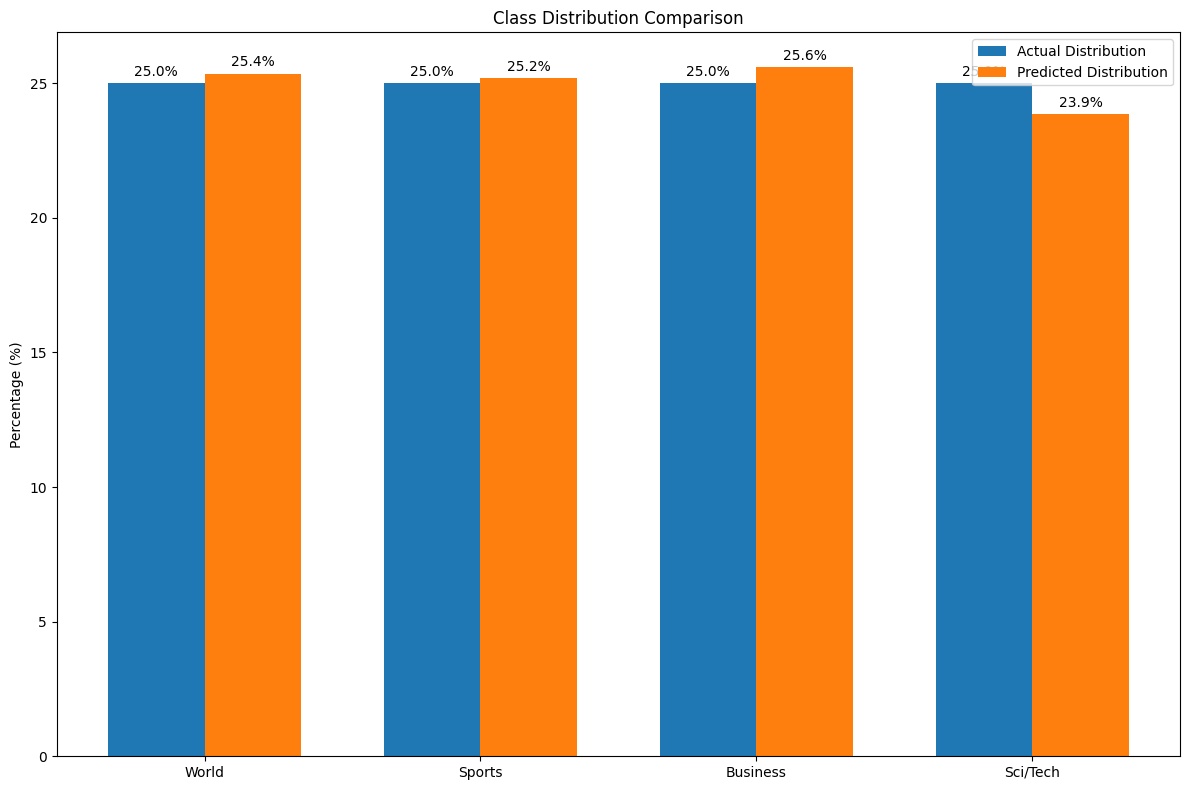

In [9]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"World category F1 score: {eval_results['eval_f1_world']:.4f}")
print(f"Sports category F1 score: {eval_results['eval_f1_sports']:.4f}")
print(f"Business category F1 score: {eval_results['eval_f1_business']:.4f}")
print(f"Sci/Tech category F1 score: {eval_results['eval_f1_scitech']:.4f}")
print(f"Business and Sci/Tech balance: {eval_results['eval_business_scitech_balance']:.4f}")

# Plot class distribution chart
def plot_class_distribution(eval_results):
    import matplotlib.pyplot as plt

    # Actual label distribution
    actual_counts = [
        eval_results['eval_world_count'],
        eval_results['eval_sports_count'],
        eval_results['eval_business_count'],
        eval_results['eval_scitech_count']
    ]
    actual_total = sum(actual_counts)
    actual_percents = [count/actual_total*100 for count in actual_counts]

    # Predicted label distribution
    pred_counts = [
        eval_results['eval_pred_world_count'],
        eval_results['eval_pred_sports_count'],
        eval_results['eval_pred_business_count'],
        eval_results['eval_pred_scitech_count']
    ]
    pred_total = sum(pred_counts)
    pred_percents = [count/pred_total*100 for count in pred_counts]

    # Create chart
    categories = ['World', 'Sports', 'Business', 'Sci/Tech']

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(len(categories))
    width = 0.35

    rects1 = ax.bar(x - width/2, actual_percents, width, label='Actual Distribution')
    rects2 = ax.bar(x + width/2, pred_percents, width, label='Predicted Distribution')

    ax.set_ylabel('Percentage (%)')
    ax.set_title('Class Distribution Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()

# Plot evaluation results class distribution
try:
    plot_class_distribution(eval_results)
except KeyError as e:
    print(f"Error while plotting class distribution chart: {e}")
    print("Some keys may be missing in the evaluation results, skipping the plotting step.")

In [10]:
# Load test set and make predictions
print("\nPlease upload test_unlabelled.pkl file...")
uploaded = files.upload()

print("Processing uploaded file...")
test_file = next(iter(uploaded.keys()))

# Load uploaded test data
with open(test_file, "rb") as f:
    test_dataset_unlabelled = pickle.load(f)

# Convert to HuggingFace dataset format
test_dataset_hf = Dataset.from_dict({"text": test_dataset_unlabelled["text"]})
print(f"Loaded test set size: {len(test_dataset_hf)} samples")

# Apply the same preprocessing to test data as was used for training data
def preprocess_test_data(examples):
    """Apply the same cleaning and tokenization processing to test data"""
    # First clean the text
    cleaned_texts = []
    for text in examples["text"]:
        # Remove URLs
        text = re.sub(r"http\S+|www\.\S+", "", text)

        # Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()

        # Remove escape characters (like &gt;)
        text = re.sub(r"&\w+;", "", text)

        # Replace newlines and tabs with spaces
        text = text.replace("\n", " ").replace("\t", " ")

        # Compress extra spaces
        text = " ".join(text.split())
        cleaned_texts.append(text)

    # Then apply tokenization
    tokenized = tokenizer(
        cleaned_texts,
        truncation=True,
        padding="max_length",
        max_length=128
    )

    return tokenized

# Apply preprocessing and tokenization
tokenized_test_dataset = test_dataset_hf.map(preprocess_test_data, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create PyTorch DataLoader for batch processing
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

# Generate predictions on test data
print("\nGenerating test predictions...")
model.eval()
all_predictions = []

# Inference without gradients
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        # Get probability distribution
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Get predictions and confidence
        confidence, preds = torch.max(probs, dim=-1)

        # For low confidence samples, especially potential confusion between Business and Sci/Tech, apply rules
        for i, (conf, pred) in enumerate(zip(confidence, preds)):
            # If confidence is low and prediction is Sci/Tech, check if it should be reclassified as Business
            if conf.item() < 0.7 and pred.item() == 3:  # Sci/Tech
                # Get Business category probability
                business_prob = probs[i, 2].item()

                # If Business probability is close, prefer Business
                if business_prob > 0.3:  # This threshold can be adjusted as needed
                    preds[i] = 2  # Change to Business

            all_predictions.append(preds[i].cpu().item())

# Save predictions to CSV file
df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),
    "Label": all_predictions
})
df.to_csv("submission.csv", index=False)
print("✅ Predictions completed. Saved to submission.csv file.")

# Analyze prediction class distribution
pred_counts = pd.Series(all_predictions).value_counts().sort_index()
print("\nPrediction class distribution:")
for i, count in enumerate(pred_counts):
    class_name = ["World", "Sports", "Business", "Sci/Tech"][i]
    percent = count / len(all_predictions) * 100
    print(f"{class_name}: {count} ({percent:.2f}%)")

# Download the generated CSV file
files.download("submission.csv")


Please upload test_unlabelled.pkl file...


Saving test_unlabelled.pkl to test_unlabelled.pkl
Processing uploaded file...
Loaded test set size: 8000 samples


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]


Generating test predictions...
✅ Predictions completed. Saved to submission.csv file.

Prediction class distribution:
World: 1566 (19.57%)
Sports: 2012 (25.15%)
Business: 2117 (26.46%)
Sci/Tech: 2305 (28.81%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>